In [24]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from pycocotools.coco import COCO

import torchvision
from torchvision.transforms import v2 as T
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate

In [25]:
torch.cuda.empty_cache()

transform = T.Compose([
    T.ToTensor(),
    T.Resize((255, 255)),
])

True
1
0
NVIDIA RTX A4000


In [27]:
class CustomCocoDataset(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None):
        """
        Args:
            annotation_file (str): Path to the COCO-format annotation file.
            img_dir (str): Path to the directory containing images.
            transform (callable, optional): A function/transform to apply to the images and annotations.
        """
        self.coco = COCO(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.img_ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        # Get image ID and metadata
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]

        # Load the image
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        # Extract bounding boxes, labels, and masks
        boxes = []
        labels = []
        masks = []
        for ann in annotations:
            x_min, y_min, width, height = ann['bbox']
            boxes.append([x_min, y_min, x_min + width, y_min + height])
            labels.append(ann['category_id'])
            masks.append(self.coco.annToMask(ann))

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([img_id]),
            "area": torch.tensor([ann['area'] for ann in annotations], dtype=torch.float32),
            "iscrowd": torch.tensor([ann['iscrowd'] for ann in annotations], dtype=torch.int64),
        }

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, target

In [28]:
train_dataset = CustomCocoDataset(
    annotation_file="./leaf_mask/train/_annotations.coco.json", 
    img_dir="./leaf_mask/train", 
    transform=transform
)

val_dataset = CustomCocoDataset(
    annotation_file="./leaf_mask/valid/_annotations.coco.json", 
    img_dir="./leaf_mask/valid", 
    transform=transform
)

test_dataset = CustomCocoDataset(
    annotation_file="./leaf_mask/test/_annotations.coco.json", 
    img_dir="./leaf_mask/test", 
    transform=transform
)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [29]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

def collate_fn(batch):
    return tuple(zip(*batch))

In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

# define training and validation data loaders
data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn
)

data_loader_val = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn
)

data_loader_test = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn
)

In [31]:
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.0001,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.5
)

In [49]:
# Function to calculate confusion matrix
def calculate_confusion_matrix(model, data_loader, device, iou_threshold=0.5):
    """
    Function to compute a confusion matrix for evaluation.
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for target, output in zip(targets, outputs):
                gt_labels = target["labels"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()

                # Assuming IOU thresholding logic here
                if len(pred_labels) == 0:
                    pred_labels = [0] * len(gt_labels)  # Treat as background if no predictions
                
                y_true.extend(gt_labels)
                y_pred.extend(pred_labels)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])  # Assuming 0=background, 1=leaf
    return conf_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plot confusion matrix using sklearn's ConfusionMatrixDisplay.
    """
    display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    display.plot(cmap="viridis", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
    
def visualize_predictions(model, data_loader, device, num_images=5):
    """
    Visualize predictions on a few test images with original image and predicted masks.
    The masks are applied on the original image using blue color.
    """
    model.eval()
    fig, axes = plt.subplots(num_images, 2, figsize=(12, 5 * num_images))
    axes = axes.reshape(num_images, 2)  # Ensure 2 columns per row (original image and predicted mask)

    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            if i >= num_images:  # Stop after visualizing desired number of images
                break

            image = images[0].to(device)  # Take the first image from the batch
            target = targets[0]
            output = model([image])[0]  # Get predictions

            # Convert tensors to CPU for visualization
            image_cpu = image.cpu().permute(1, 2, 0).numpy()

            # Predicted masks
            pred_masks = output["masks"].cpu().numpy() > 0.5  # Threshold predictions at 0.5

            # Display the original image
            axes[i, 0].imshow(image_cpu)
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis("off")

            # Overlay all predicted masks in blue on the original image
            axes[i, 1].imshow(image_cpu)
            for pred_mask in pred_masks:
                pred_mask = np.squeeze(pred_mask)  # Remove channel dimension
                # Apply blue color to the mask
                axes[i, 1].imshow(pred_mask, alpha=0.5, cmap="Blues", vmin=0, vmax=1)
            axes[i, 1].set_title("Predicted Masks")
            axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

In [33]:
# let's train it just for 2 epochs
num_epochs = 220

loss_history = []

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_losses = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=75)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    metrics = evaluate(
        model, 
        data_loader_test, 
        device=torch.device("cuda"), 
        iou_threshold=0.5, 
        class_names=["background", "leaf"]
    )

    print("Evaluation Metrics:", metrics)
    
    conf_matrix = calculate_confusion_matrix(model, data_loader_test, device)
    # print("Confusion Matrix:\n", conf_matrix)
    plot_confusion_matrix(conf_matrix, class_names=["background", "leaf"])

Epoch: [0]  [ 0/94]  eta: 0:04:22  lr: 0.000001  loss: 4.2127 (4.2127)  loss_classifier: 0.4378 (0.4378)  loss_box_reg: 0.4560 (0.4560)  loss_mask: 1.4808 (1.4808)  loss_objectness: 1.7818 (1.7818)  loss_rpn_box_reg: 0.0563 (0.0563)  time: 2.7890  data: 1.4033  max mem: 12295


KeyboardInterrupt: 

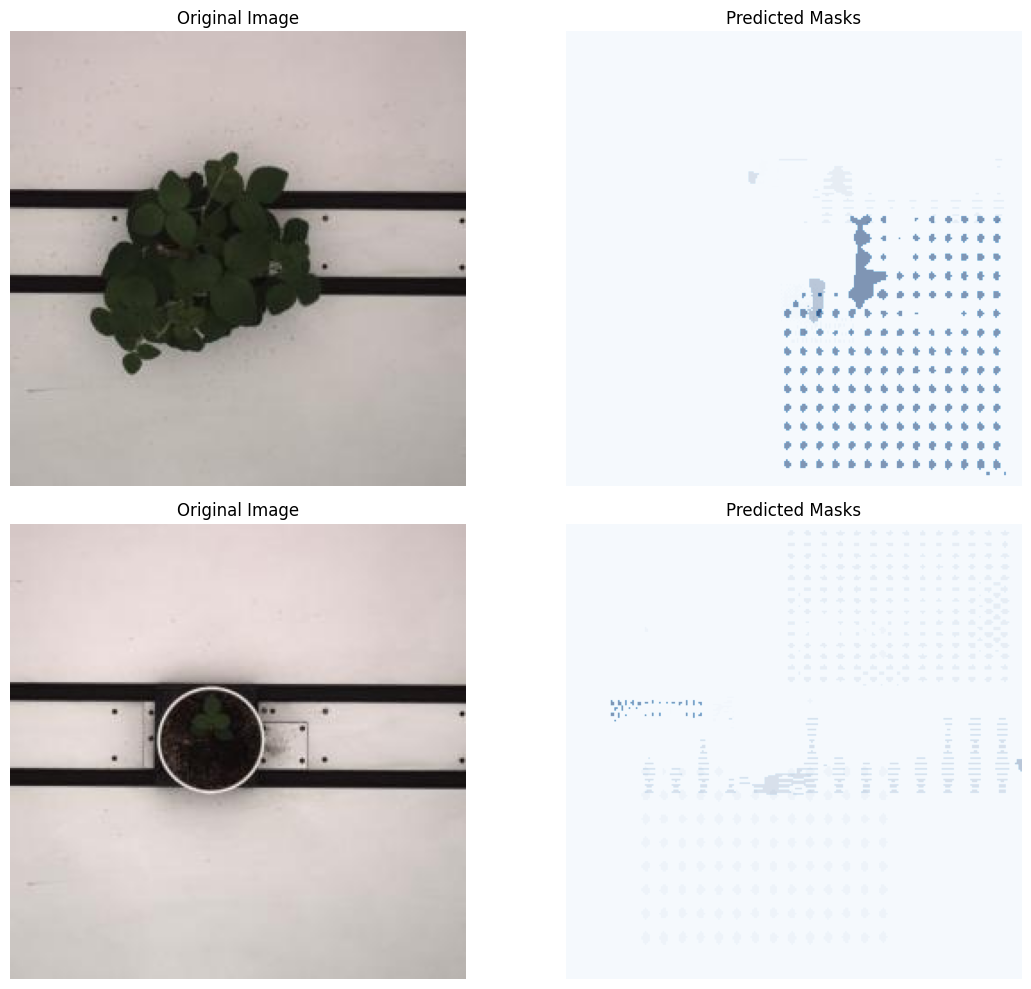

In [48]:
visualize_predictions(model, data_loader_test, device, num_images=2)